# CIFAR10 Classifier. Training


This is the third part of the tutorial on how to train a classifier on CIFAR10 dataset. 

Here we will assemble the results of two previous parts and train a model on CIFAR10.

- Setup dataflow
- Setup model: SqueezeNet v1.1

References:
- [pytorch-examples/imagenet](https://github.com/pytorch/examples/blob/master/imagenet/main.py)


In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [6]:
import os, sys
import torch
import torchvision

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
os.environ['CIFAR10_ROOT'] = '/media/user/fast_storage/tensorpack_data/cifar10_data/'

In [7]:
CIFAR10_ROOT = os.environ['CIFAR10_ROOT']
sys.path.append("common")

## Setup dataflow

Again, we have two CIFAR10 datasets: `training` and `testing`. Next, we :
- separate training dataset using stratified split into `n` folds of `training` and `validation` datasets.
- apply data augmentations
- gather data in batches
- all previous operations using multiprocessing
- load on GPU

We won't iterate over folds and consider only the first fold


In [16]:
from torchvision.transforms import Compose, Normalize, ToTensor, Lambda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from common.dataflow import TransformedDataset, OnCudaDataLoader
from common.imgaug import ToNumpy, RandomOrder, RandomChoice, RandomFlip, RandomAffine, RandomAdd

In [9]:
# Raw datasets: training and testing
train_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=True, download=False)
test_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=False, download=False)

In [12]:
from sklearn.model_selection import StratifiedKFold

n_samples = len(train_ds)
X = np.zeros(n_samples)
Y = np.zeros(n_samples)
for i, (_, label) in enumerate(train_ds):
    Y[i] = label

kfolds_train_indices = []
kfolds_val_indices = []
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
for train_indices, val_indices in skf.split(X, Y):
    kfolds_train_indices.append(train_indices)
    kfolds_val_indices.append(val_indices)  
    
kfold_samplers = []
for train_indices, val_indices in zip(kfolds_train_indices, kfolds_val_indices):
    kfold_samplers.append({"train": SubsetRandomSampler(train_indices), 
                           "val": SubsetRandomSampler(val_indices)})

In [13]:
# Data augmentations

mean_val = [0.5] * 3  # RGB
std_val = [0.5] * 3  # RGB

train_transforms = Compose([
    ToNumpy(),
    # Geometry
    RandomChoice([
        RandomAffine(rotation=(-60, 60), scale=(0.95, 1.05), translate=(0.05, 0.05)),
        RandomFlip(proba=0.5, mode='h'),
        RandomFlip(proba=0.5, mode='v'),        
    ]),    
    # Color
    RandomChoice([
       RandomAdd(value=(-50, 10), per_channel=0),
       RandomAdd(value=(-50, 10), per_channel=1),
       RandomAdd(value=(-50, 10), per_channel=2),
       RandomAdd(value=(-30, 30))
    ]),
    # To Tensor (float, CxHxW, [0.0, 1.0]) + Normalize
    ToTensor(),
    Normalize(mean_val, std_val)
])
  

test_transforms = Compose([
    ToNumpy(),    
    # Geometry
    RandomChoice([
        RandomAffine(rotation=(-60, 60), scale=(0.95, 1.05), translate=(0.05, 0.05)),
        RandomFlip(proba=0.5, mode='h'),
        RandomFlip(proba=0.5, mode='v'),        
    ]),        
    # Color
    RandomAdd(value=(-10, 10)),
    # To Tensor (float, CxHxW, [0.0, 1.0])  + Normalize
    ToTensor(),
    Normalize(mean_val, std_val)
])

label_to_tensor = Lambda(lambda y: torch.LongTensor([y]))

In [14]:
data_aug_train_ds = TransformedDataset(train_ds, x_transforms=train_transforms, y_transforms=label_to_tensor)
data_aug_val_ds = TransformedDataset(train_ds, x_transforms=test_transforms, y_transforms=label_to_tensor)

In [17]:
split_index = 0 

cuda_train_batches_ds = OnCudaDataLoader(data_aug_train_ds, 
                                         batch_size=64, 
                                         sampler=kfold_samplers[split_index]["train"], 
                                         num_workers=4, 
                                         drop_last=True, 
                                         pin_memory=True)
cuda_val_batches_ds = OnCudaDataLoader(data_aug_val_ds, 
                                       batch_size=64, 
                                       sampler=kfold_samplers[split_index]["val"], 
                                       num_workers=4, 
                                       drop_last=True)

Let's check again training classes distribution:

In [22]:
import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

In [37]:
n_classes = 10
mean_n_classes = []
std_n_classes = []
cnt = 0

classes_stats_per_batches = np.zeros((len(cuda_train_batches_ds), n_classes), dtype=np.int)

for i, (batch_x, batch_y) in enumerate(cuda_train_batches_ds):
    
    for ty in batch_y:
        y = ty.cpu().numpy()[0]
        classes_stats_per_batches[i, y] += 1

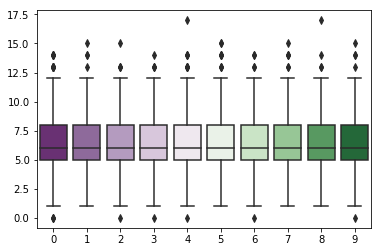

In [39]:
sns.boxplot(data=classes_stats_per_batches, palette="PRGn")

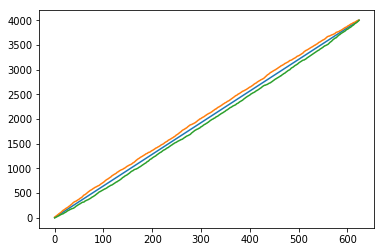

In [42]:
mean_n_classes = np.mean(np.cumsum(classes_stats_per_batches, axis=0), axis=1)
std_n_classes = np.std(np.cumsum(classes_stats_per_batches, axis=0), axis=1)

plt.plot(mean_n_classes)
plt.plot(mean_n_classes + 3.0 * std_n_classes)
plt.plot(mean_n_classes - 3.0 * std_n_classes)

## Setup model

Let's load a small neural network "SqueezeNet" that has only ~700K parameters, but shows good performances

References:
- [paper](https://arxiv.org/pdf/1602.07360.pdf)

In [46]:
from torchvision.models import SqueezeNet

from common.nn_utils import print_trainable_parameters

In [47]:
squeezenet = SqueezeNet(num_classes=10, version=1.1)
print(squeezenet)

SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire (
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (4): Fire (
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1,

In [48]:
print_trainable_parameters(squeezenet)

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.3.squeeze.weight torch.Size([16, 64, 1, 1])
features.3.squeeze.bias torch.Size([16])
features.3.expand1x1.weight torch.Size([64, 16, 1, 1])
features.3.expand1x1.bias torch.Size([64])
features.3.expand3x3.weight torch.Size([64, 16, 3, 3])
features.3.expand3x3.bias torch.Size([64])
features.4.squeeze.weight torch.Size([16, 128, 1, 1])
features.4.squeeze.bias torch.Size([16])
features.4.expand1x1.weight torch.Size([64, 16, 1, 1])
features.4.expand1x1.bias torch.Size([64])
features.4.expand3x3.weight torch.Size([64, 16, 3, 3])
features.4.expand3x3.bias torch.Size([64])
features.6.squeeze.weight torch.Size([32, 128, 1, 1])
features.6.squeeze.bias torch.Size([32])
features.6.expand1x1.weight torch.Size([128, 32, 1, 1])
features.6.expand1x1.bias torch.Size([128])
features.6.expand3x3.weight torch.Size([128, 32, 3, 3])
features.6.expand3x3.bias torch.Size([128])
features.7.squeeze.weight torch.Size([32, 256, 

Let's put the model on GPU

In [49]:
squeezenet = squeezenet.cuda()

## Setup loss function and optimizer

Let's choose classical cross-entropy loss function for this multiclass classification task and Adam as an optimizer.

In [52]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

In [53]:
# define loss function (criterion) and optimizer
criterion = CrossEntropyLoss().cuda()
optimizer = Adam(squeezenet.parameters(), lr=0.001)

## Setup training pipeline

Typical pipeline: 
- loops over training dataset during `n_epochs`
    - computes values of the loss function, accuracy, other metrics on train batches
- runs validation phase on validation dataset when training epoch ends
    - computes values of the loss function, accuracy, other metrics on whole validation dataset
- save on the disk the best model defined by a metric
- performs learning rate scheduling on each training epoch


Next, there are two ways:
- copy/modify code from examples: i.e. [link](https://github.com/pytorch/examples/blob/master/imagenet/main.py)
- use [tnt](https://github.com/pytorch/tnt) or [torchsample](https://github.com/ncullen93/torchsample) ...


In [54]:
from torch.backends import cudnn


> What does torch.backends.cudnn.benchmark do ? [url](https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/2)

In [57]:
cudnn.benchmark

False

In [63]:
from torch.utils.trainer import Trainer, plugins

In [62]:
Trainer??

In [64]:
plugins??